The goal is to come up with tighten dSA cuts to ensure quality, while not loosing good signals.
By saying GOOD, I mean good pT resolution tracks.
could do matching gen muons with dSA muons for larger decay length signals, tighten pt matching criteria step by step.

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import json
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [26]:
class myprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        nvalhits_axis = hist.Bin('nvalhits', '# valid MS hits', 60, 0, 60)
        nvalstas_axis = hist.Bin('nvalstas', '# valid MS', 5, 0, 5)
        normchi2_axis = hist.Bin('normchi2', 'Normalized $\chi^2$', 25, 0, 5)
        pterrpt_axis = hist.Bin('pterrorpt', '$\sigma_{p_T}/p_T$', 25, 0, 5)
        dpt_axis = hist.Cat('dpt', 'deltaPtCut')
        self._accumulator = processor.dict_accumulator({
            'nvalhits': hist.Hist('Counts', dataset_axis, nvalhits_axis, dpt_axis),
            'nvalstas': hist.Hist('Counts', dataset_axis, nvalstas_axis, dpt_axis),
            'normchi2': hist.Hist('Counts', dataset_axis, normchi2_axis, dpt_axis),
            'pterrpr': hist.Hist('Counts', dataset_axis, pterrpt_axis, dpt_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fZ'],
            pid=df['gen_pid'],
        )
        genvxy = np.hypot(df['gen_vtx.fCoordinates.fX'], df['gen_vtx.fCoordinates.fY'])
        genparticles.add_attributes(vxy=genvxy)
        gendispmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.vxy>30)]
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            px=df['dsamuon_p4.fCoordinates.fX'],
            py=df['dsamuon_p4.fCoordinates.fY'],
            pz=df['dsamuon_p4.fCoordinates.fZ'],
            energy=df['dsamuon_p4.fCoordinates.fZ'],
            normchi2=df['dsamuon_normChi2'],
            nhits=df['dsamuon_nValStaHits'],
            nstas=df['dsamuon_nStaValHits'], 
            pterr=df['dsamuon_ptErr']
        )
        dsamuons.add_attributes(pterrpt=(dsamuons.pterr/dsamuons.pt))
        dsamuons = dsamuons[(dsamuons.pt>20)&(np.abs(dsamuons.eta)<2.4)&(dsamuons.nstas>1)&(dsamuons.normchi2<10)]
        
        matchmask = dsamuons.match(gendispmuons, deltaRCut=0.3)
        matchmask10 = dsamuons.match(gendispmuons, deltaRCut=0.3, deltaPtCut=10)
        matchmask1 = dsamuons.match(gendispmuons, deltaRCut=0.3, deltaPtCut=1)
        matchmask0p5 = dsamuons.match(gendispmuons, deltaRCut=0.3, deltaPtCut=0.5)
        matchmask0p1 = dsamuons.match(gendispmuons, deltaRCut=0.3, deltaPtCut=0.1)

        mdsas = dsamuons[matchmask]
        output['nvalhits'].fill(dataset=dataset, nvalhits=mdsas.nhits.flatten(), dpt='1e4')
        output['nvalstas'].fill(dataset=dataset, nvalstas=mdsas.nstas.flatten(), dpt='1e4')
        output['normchi2'].fill(dataset=dataset, normchi2=mdsas.normchi2.flatten(), dpt='1e4')
        output['pterrpr'].fill(dataset=dataset, pterrorpt=mdsas.pterrpt.flatten(), dpt='1e4')
        
        mdsas = dsamuons[matchmask10]
        output['nvalhits'].fill(dataset=dataset, nvalhits=mdsas.nhits.flatten(), dpt=' 10')
        output['nvalstas'].fill(dataset=dataset, nvalstas=mdsas.nstas.flatten(), dpt=' 10')
        output['normchi2'].fill(dataset=dataset, normchi2=mdsas.normchi2.flatten(), dpt=' 10')
        output['pterrpr'].fill(dataset=dataset, pterrorpt=mdsas.pterrpt.flatten(), dpt=' 10')
        
        mdsas = dsamuons[matchmask1]
        output['nvalhits'].fill(dataset=dataset, nvalhits=mdsas.nhits.flatten(), dpt='  1')
        output['nvalstas'].fill(dataset=dataset, nvalstas=mdsas.nstas.flatten(), dpt='  1')
        output['normchi2'].fill(dataset=dataset, normchi2=mdsas.normchi2.flatten(), dpt='  1')
        output['pterrpr'].fill(dataset=dataset, pterrorpt=mdsas.pterrpt.flatten(), dpt='  1')
        
        mdsas = dsamuons[matchmask0p5]
        output['nvalhits'].fill(dataset=dataset, nvalhits=mdsas.nhits.flatten(), dpt='0.5')
        output['nvalstas'].fill(dataset=dataset, nvalstas=mdsas.nstas.flatten(), dpt='0.5')
        output['normchi2'].fill(dataset=dataset, normchi2=mdsas.normchi2.flatten(), dpt='0.5')
        output['pterrpr'].fill(dataset=dataset, pterrorpt=mdsas.pterrpt.flatten(), dpt='0.5')
        
        mdsas = dsamuons[matchmask0p1]
        output['nvalhits'].fill(dataset=dataset, nvalhits=mdsas.nhits.flatten(), dpt='0.1')
        output['nvalstas'].fill(dataset=dataset, nvalstas=mdsas.nstas.flatten(), dpt='0.1')
        output['normchi2'].fill(dataset=dataset, normchi2=mdsas.normchi2.flatten(), dpt='0.1')
        output['pterrpr'].fill(dataset=dataset, pterrorpt=mdsas.pterrpt.flatten(), dpt='0.1')
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [27]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  1.25items/s]


0 2mu2e/mXX-1000_mA-0p25_lxy-300
1 2mu2e/mXX-100_mA-5_lxy-300
2 4mu/mXX-1000_mA-0p25_lxy-300
3 4mu/mXX-100_mA-5_lxy-300


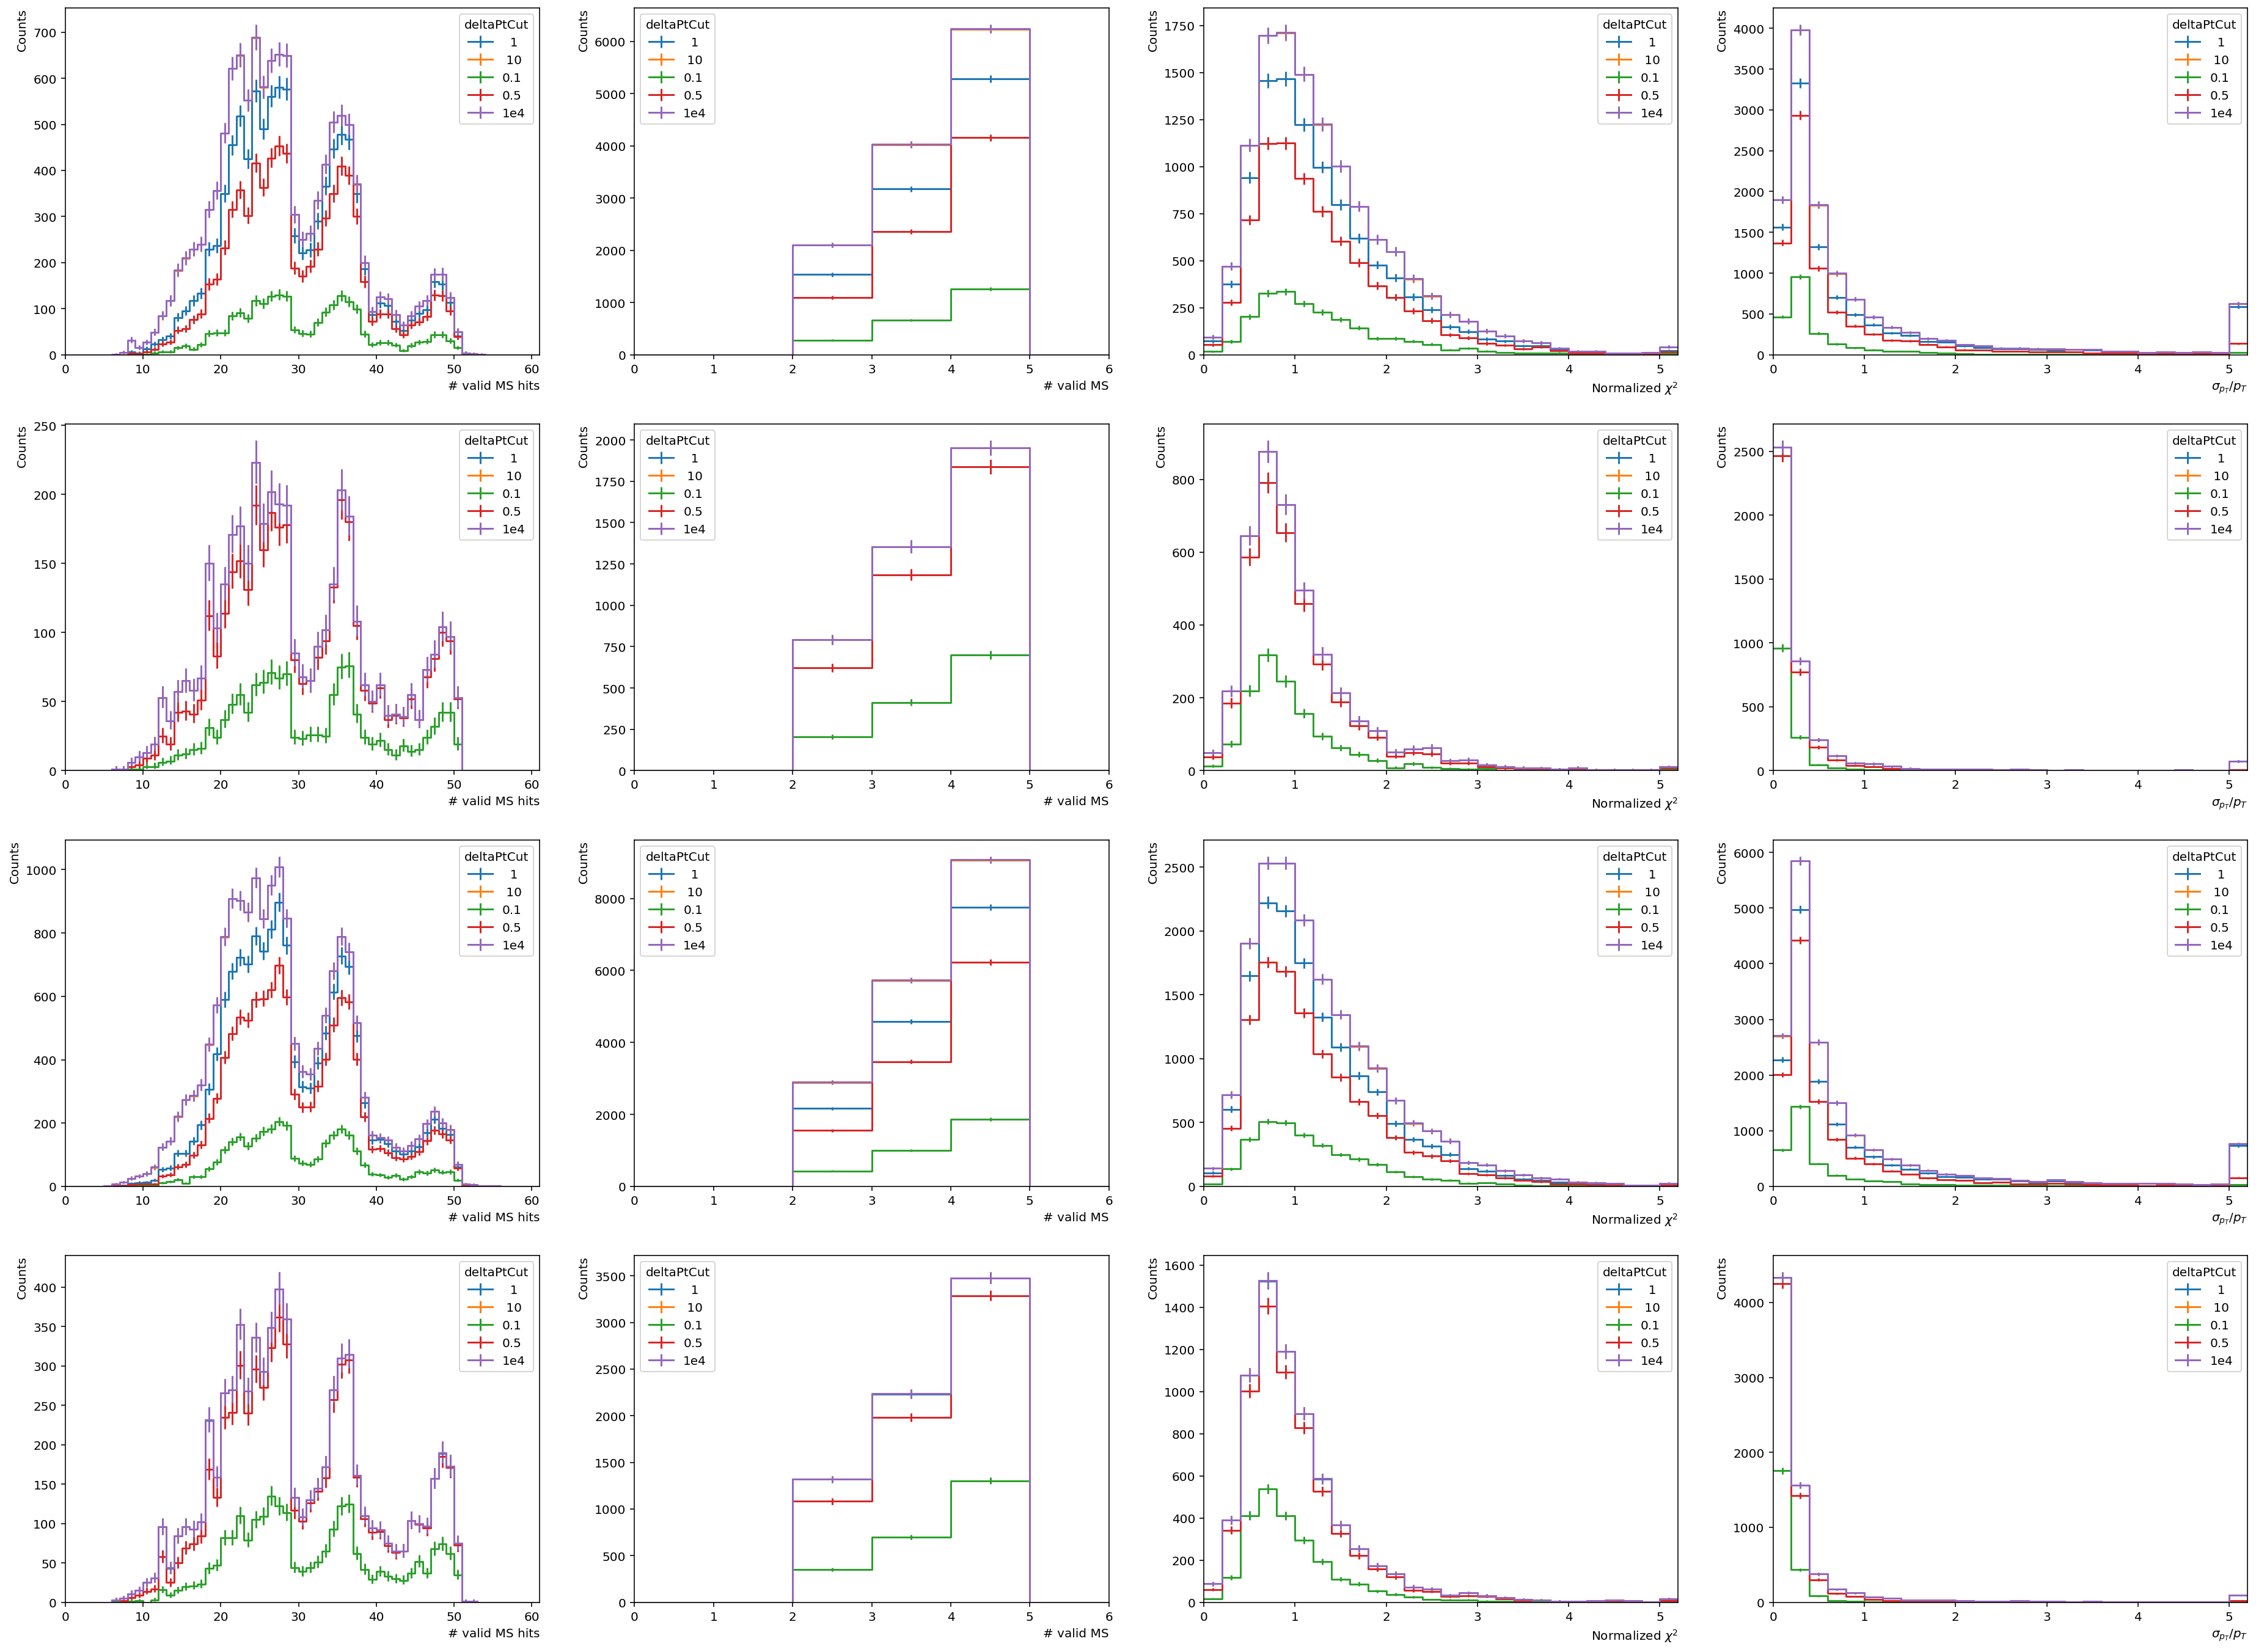

In [29]:

dsids = output['nvalhits'].identifiers('dataset')
fig, axes = plt.subplots(len(dsids),4, figsize=(32, 6*len(dsids)))
for i, ds in enumerate(dsids):
    print(i, ds)
    hist.plot1d(output['nvalhits'].integrate('dataset', ds), overlay='dpt', overflow='over', ax=axes[i][0], density=False)
    hist.plot1d(output['nvalstas'].integrate('dataset', ds), overlay='dpt', overflow='over', ax=axes[i][1], density=False)
    hist.plot1d(output['normchi2'].integrate('dataset', ds), overlay='dpt', overflow='over', ax=axes[i][2], density=False)
    hist.plot1d(output['pterrpr'].integrate('dataset', ds), overlay='dpt', overflow='over', ax=axes[i][3], density=False)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

In [15]:
output['nvalhits'].identifiers('dataset')

[<StringBin (2mu2e/mXX-1000_mA-0p25_lxy-300) instance at 0x7fc1493ed5f8>,
 <StringBin (2mu2e/mXX-100_mA-5_lxy-300) instance at 0x7fc1494336d8>,
 <StringBin (4mu/mXX-1000_mA-0p25_lxy-300) instance at 0x7fc149450128>,
 <StringBin (4mu/mXX-100_mA-5_lxy-300) instance at 0x7fc1492a1080>]